<a href="https://colab.research.google.com/github/Kinjalah/House_Price_Prediction/blob/main/HousepricePredictionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


df=pd.read_csv("Punedata.csv")

##############################################################################################################################
# Removing the unnecessary columns..
###############################################################################################################################

if 'area_type' in df.columns:
  df.drop('area_type',axis=1,inplace=True)
else:
  print("Column 'area_type' not found in DataFrame.")

if 'society' in df.columns:
  df = df.drop('society', axis='columns')
else:
  print("Column 'society' not found in DataFrame.")

if 'availability' in df.columns:
  df.drop('availability',axis=1,inplace=True)
else:
  print("Column 'availability' not found in DataFrame.")


###############################################################################################################################
# Handleling Null VAlues
###############################################################################################################################

from math import floor
balcony_mean = float(floor(df.balcony.mean()))
bath_mean = float(floor(df.bath.mean()))
df.balcony = df.balcony.fillna(balcony_mean)
df.bath = df.bath.fillna(bath_mean)

df.dropna(subset=['size'], inplace=True)

###############################################################################################################################
# Formatting some columns to integer values only
###############################################################################################################################

# Converting the size column to bhk
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
df = df.drop('size', axis='columns')
df.groupby('bhk')['bhk'].agg('count')

# Since the total_sqft contains range values such as 1133-1384, lets filter out these values
def isFloat(x):
    try:
        float(x)
    except:
        return False
    return True

# Converting the range values to integer values and removing other types of error
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

df['new_total_sqft'] = df.total_sqft.apply(convert_sqft_to_num)
df = df.drop('total_sqft', axis='columns')

# Removing the rows in new_total_sqft column that hase None values
df = df.dropna()

#########################################################################################################################################
#  REMOVING OUTLIERS #
#########################################################################################################################################

# For BHK
q1=df['bhk'].quantile(0.25)
q3=df['bhk'].quantile(0.75)
IQR=q3-q1
lower_bound=q1-1.5*IQR
upper_bound=q3+1.5*IQR
df=df[(df["bhk"]>=lower_bound)&(df["bhk"]<=upper_bound)]

# for 'new_total_sqft'
Q1_sqft = df['new_total_sqft'].quantile(0.25)
Q3_sqft = df['new_total_sqft'].quantile(0.75)
IQR_sqft = Q3_sqft - Q1_sqft
lower_bound_sqft = Q1_sqft - 1.5 * IQR_sqft
upper_bound_sqft = Q3_sqft + 1.5 * IQR_sqft
df=df[(df["new_total_sqft"]>=lower_bound_sqft)&(df["new_total_sqft"]<=upper_bound_sqft)]

#for PRICE

Q1=df['price'].quantile(0.25)
Q3=df['price'].quantile(0.75)
IQR=Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR
df=df[(df['price']>=lower_bound)&(df['price']<=upper_bound)]

##############################################################################################################################################
#Feature Engineering
##############################################################################################################################################

# Adding a new column of price_per_sqft
df1 = df.copy()
# In our dataset the price column is in Lakhs
df1['price_per_sqft'] = (df1['price']*100000)/df1['new_total_sqft']

# Removing the extra spaces at the end
df1.location = df1.location.apply(lambda x: x.strip())

# Calulating all the unqiue values in 'location' column
location_stats = df1.groupby('location')['location'].agg('count').sort_values(ascending=False)

# Labelling the locations with less than or equal to 10 occurences to 'other'
locations_less_than_10 = location_stats[location_stats<=10]

df1.location = df1.location.apply(lambda x: 'other' if x in locations_less_than_10 else x)

# Removing the rows that have 1 Room for less than 300sqft

df2 = df1[~(df1.new_total_sqft/df1.bhk<300)]


# Since there is a wide range for 'price_per_sqft' column with min = Rs.267/sqft till max = Rs. 127470/sqft, we remove the extreme ends using the SD
def remove_pps_outliers(df):

    df_out = pd.DataFrame()

    for key, sub_df in df.groupby('location'):
        m = np.mean(sub_df.price_per_sqft)
        sd = np.std(sub_df.price_per_sqft)
        reduce_df = sub_df[(sub_df.price_per_sqft>(m-sd)) & (sub_df.price_per_sqft<(m+sd))]
        df_out = pd.concat([df_out, reduce_df], ignore_index=True)

    return df_out

df3 = remove_pps_outliers(df2)

# Here we observe that 3 BHK cost that same as 2 BHK in 'Hebbal' location hence removing such outliers is necessary
def remove_bhk_outliers(df):
    exclude_indices = np.array([])

    for location, location_df in df.groupby('location'):
        bhk_stats = {}

        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }

        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)

    return df.drop(exclude_indices, axis='index')

df4 = remove_bhk_outliers(df3)

# Removing the rows that have 'bath' greater than 'bhk'+2
df5 = df4[df4.bath<(df4.bhk+2)]
print("all set with preprocessing !")

all set with preprocessing !


In [ ]:
q1=df['bhk'].quantile(0.25)
q3=df['bhk'].quantile(0.75)
IQR=q3-q1
lower_bound=q1-1.5*IQR
upper_bound=q3+1.5*IQR
df=df[(df["bhk"]>=lower_bound)&(df["bhk"]<=upper_bound)]

# for 'new_total_sqft'
Q1_sqft = df['new_total_sqft'].quantile(0.25)
Q3_sqft = df['new_total_sqft'].quantile(0.75)
IQR_sqft = Q3_sqft - Q1_sqft
lower_bound_sqft = Q1_sqft - 1.5 * IQR_sqft
upper_bound_sqft = Q3_sqft + 1.5 * IQR_sqft
df=df[(df["new_total_sqft"]>=lower_bound_sqft)&(df["new_total_sqft"]<=upper_bound_sqft)]

#for PRICE

Q1=df['price'].quantile(0.25)
Q3=df['price'].quantile(0.75)
IQR=Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR
df=df[(df['price']>=lower_bound)&(df['price']<=upper_bound)]

##############################################################################################################################################
#Feature Engineering
##############################################################################################################################################

# Adding a new column of price_per_sqft
df1 = df.copy()
# In our dataset the price column is in Lakhs
df1['price_per_sqft'] = (df1['price']*100000)/df1['new_total_sqft']

# Removing the extra spaces at the end
df1.location = df1.location.apply(lambda x: x.strip())

# Calulating all the unqiue values in 'location' column
location_stats = df1.groupby('location')['location'].agg('count').sort_values(ascending=False)

# Labelling the locations with less than or equal to 10 occurences to 'other'
locations_less_than_10 = location_stats[location_stats<=10]

df1.location = df1.location.apply(lambda x: 'other' if x in locations_less_than_10 else x)

# Removing the rows that have 1 Room for less than 300sqft

df2 = df1[~(df1.new_total_sqft/df1.bhk<300)]


# Since there is a wide range for 'price_per_sqft' column with min = Rs.267/sqft till max = Rs. 127470/sqft, we remove the extreme ends using the SD
def remove_pps_outliers(df):

    df_out = pd.DataFrame()

    for key, sub_df in df.groupby('location'):
        m = np.mean(sub_df.price_per_sqft)
        sd = np.std(sub_df.price_per_sqft)
        reduce_df = sub_df[(sub_df.price_per_sqft>(m-sd)) & (sub_df.price_per_sqft<(m+sd))]
        df_out = pd.concat([df_out, reduce_df], ignore_index=True)

    return df_out

df3 = remove_pps_outliers(df2)

# Here we observe that 3 BHK cost that same as 2 BHK in 'Hebbal' location hence removing such outliers is necessary
def remove_bhk_outliers(df):
    exclude_indices = np.array([])

    for location, location_df in df.groupby('location'):
        bhk_stats = {}

        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }

        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)

    return df.drop(exclude_indices, axis='index')

df4 = remove_bhk_outliers(df3)

# Removing the rows that have 'bath' greater than 'bhk'+2
df5 = df4[df4.bath<(df4.bhk+2)]
print("all set with preprocessing !")
print(df5.head(25))

NameError: name 'df' is not defined

In [ ]:
# Calculate bounds for bhk
q1_bhk = df['bhk'].quantile(0.25)
q3_bhk = df['bhk'].quantile(0.75)
iqr_bhk = q3_bhk - q1_bhk
lower_bound_bhk = q1_bhk - 1.5 * iqr_bhk
upper_bound_bhk = q3_bhk + 1.5 * iqr_bhk

# Find outliers in bhk
bhk_outliers = df[(df['bhk'] < lower_bound_bhk) | (df['bhk'] > upper_bound_bhk)]
print("BHK Outliers:")
print(bhk_outliers)


BHK Outliers:
Empty DataFrame
Columns: [location, bath, balcony, price, bhk, new_total_sqft]
Index: []


In [ ]:
# Calculate bounds for new_total_sqft
q1_sqft = df['new_total_sqft'].quantile(0.25)
q3_sqft = df['new_total_sqft'].quantile(0.75)
iqr_sqft = q3_sqft - q1_sqft
lower_bound_sqft = q1_sqft - 1.5 * iqr_sqft
upper_bound_sqft = q3_sqft + 1.5 * iqr_sqft

# Find outliers in new_total_sqft
sqft_outliers = df[(df['new_total_sqft'] < lower_bound_sqft) | (df['new_total_sqft'] > upper_bound_sqft)]
print("New Total Sqft Outliers:")
print(sqft_outliers)


New Total Sqft Outliers:
                  location  bath  balcony  price  bhk  new_total_sqft
74           Sahakar Nagar   3.0      2.0  140.0    3          2089.0
78     Senapati Bapat Road   1.0      0.0   22.0    2           460.0
171          Salunke Vihar   1.0      1.0   11.0    1           450.0
377            Viman Nagar   1.0      0.0   29.9    1           451.0
571                Wagholi   3.0      2.0  125.0    3          2100.0
...                    ...   ...      ...    ...  ...             ...
12895             Gultekdi   1.0      1.0   20.0    1           450.0
12990        Gokhale Nagar   3.0      0.0  122.0    3          2038.5
13129         Raviwar Peth   4.0      2.0  134.0    4          2093.0
13189        Kalyani Nagar   3.0      2.0  134.0    3          2099.0
13283         Hingne Khurd   3.0      2.0  103.0    3          2111.0

[111 rows x 6 columns]


In [ ]:
# Calculate bounds for price
q1_price = df['price'].quantile(0.25)
q3_price = df['price'].quantile(0.75)
iqr_price = q3_price - q1_price
lower_bound_price = q1_price - 1.5 * iqr_price
upper_bound_price = q3_price + 1.5 * iqr_price

# Find outliers in price
price_outliers = df[(df['price'] < lower_bound_price) | (df['price'] > upper_bound_price)]
print("Price Outliers:")
print(price_outliers)


Price Outliers:
             location  bath  balcony  price  bhk  new_total_sqft
74      Sahakar Nagar   3.0      2.0  140.0    3          2089.0
299            Bopodi   3.0      1.0  140.0    3           880.0
346          Mundhawa   2.0      0.0  140.0    3          1350.0
429    Kondhwa Budruk   3.0      2.0  140.0    3          1933.0
604          Ghorpadi   3.0      2.0  140.0    3          2060.0
...               ...   ...      ...    ...  ...             ...
13144  Vadgaon Budruk   3.0      2.0  139.0    3          1760.0
13150        Wanowrie   3.0      3.0  140.0    3          1724.0
13192      Kasba Peth   3.0      0.0  140.0    3          1490.0
13296   Koregaon Park   2.0      2.0  140.0    2          1200.0
13308      Nagar Road   3.0      1.0  142.0    3          1527.0

[98 rows x 6 columns]


## Data Visualization


In [ ]:
df=df5.copy()

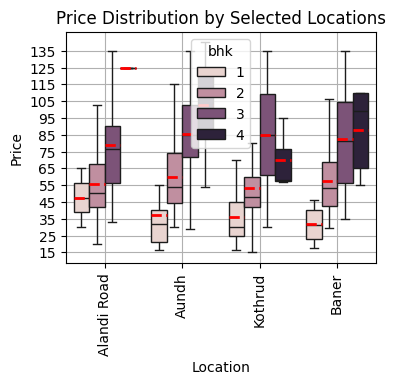

In [ ]:
# Price Distribution by Selected Locations

selected_locations = ['Alandi Road', 'Aundh', 'Baner', 'Kothrud', 'Wakad']
filtered_df = df[df['location'].isin(selected_locations)]

plt.figure(figsize=(4,3))
sns.boxplot(x=filtered_df['location'], y=filtered_df['price'], hue=filtered_df['bhk'], showfliers=False, showmeans=True, meanline=True, meanprops={"linewidth":2, "color":"red"})
plt.title('Price Distribution by Selected Locations')
plt.xlabel("Location")
plt.ylabel("Price")
plt.grid(True)
plt.yticks(range(int(filtered_df['price'].min()), int(filtered_df['price'].max()) + 1, 10))
plt.xticks(rotation=90)
plt.show()



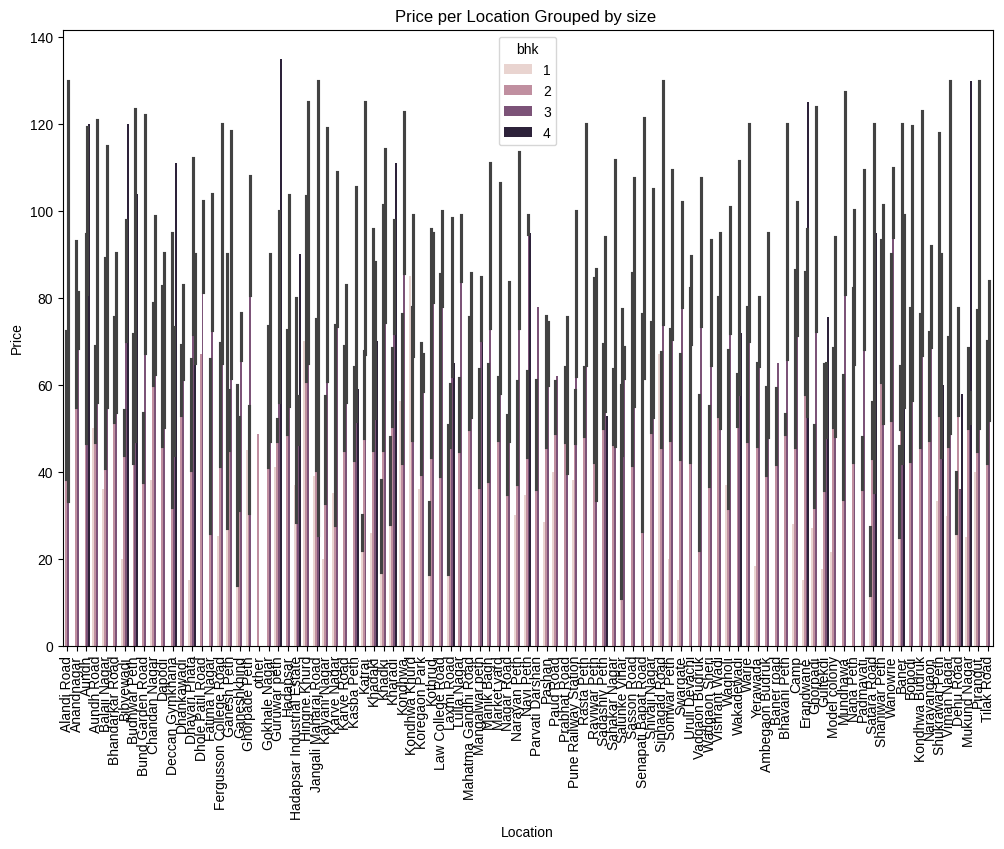

In [ ]:
# Grouped bar chart using 'hue'
plt.figure(figsize=(12,8))
sns.barplot(x="location", y="price", hue="bhk", data=df.head(1000))
plt.title("Price per Location Grouped by size ")
plt.xlabel("Location")
plt.ylabel("Price")
sns.set_context("talk")
plt.style.use("seaborn-v0_8-dark")
plt.xticks(rotation=90)
plt.show()


In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

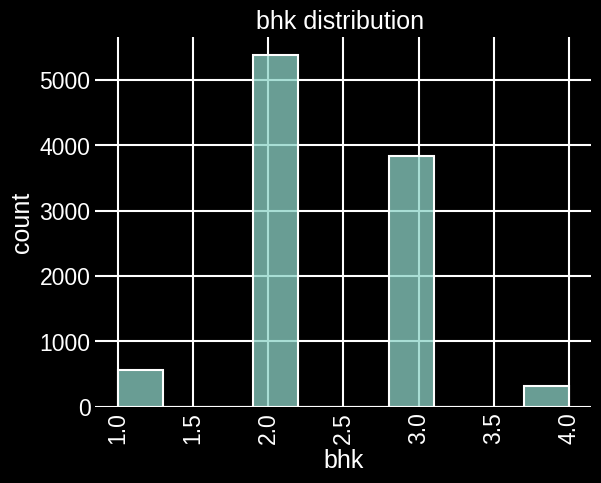

In [ ]:
plt.style.use("dark_background")
sns.histplot(df['bhk'],bins=10,kde=False)
plt.title("bhk distribution ")
plt.xlabel("bhk")
plt.ylabel("count")
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


# New Section

In [ ]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


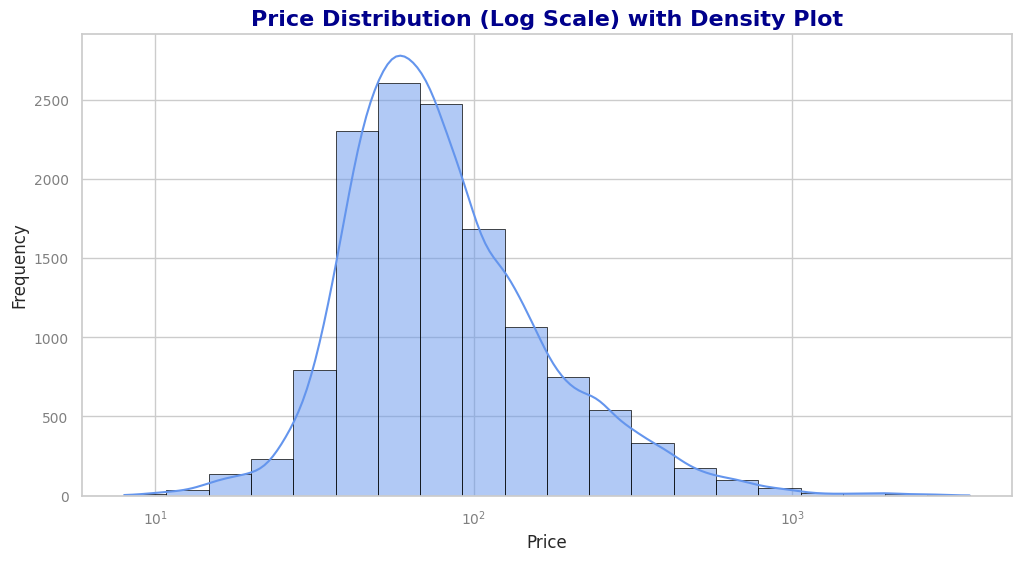

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load dataset
df = pd.read_csv("Punedata.csv")

# Set the style for the background to light
sns.set_theme(style="whitegrid")

# Create a histogram for 'price' with log scale, and add density plot
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=20, log_scale=True, kde=True, color='cornflowerblue', edgecolor='black', linewidth=0.5)

# Add title and labels
plt.title('Price Distribution (Log Scale) with Density Plot', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Customize ticks and grid
plt.xticks(fontsize=10, color='gray')
plt.yticks(fontsize=10, color='gray')

# Show the plot
plt.show()



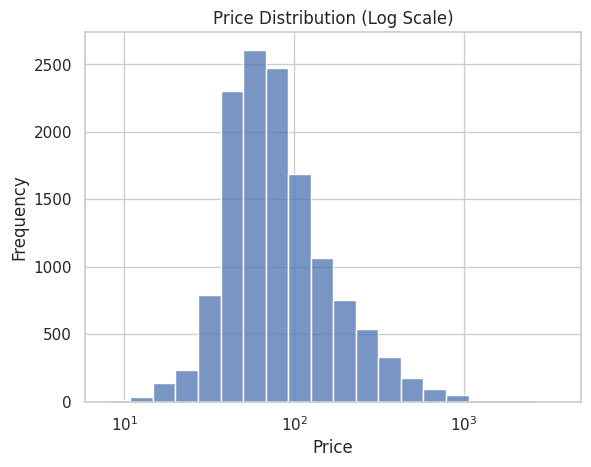

In [ ]:
sns.histplot(df['price'], bins=20, log_scale=True)
plt.title('Price Distribution (Log Scale)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.style.use("classic")
plt.show()


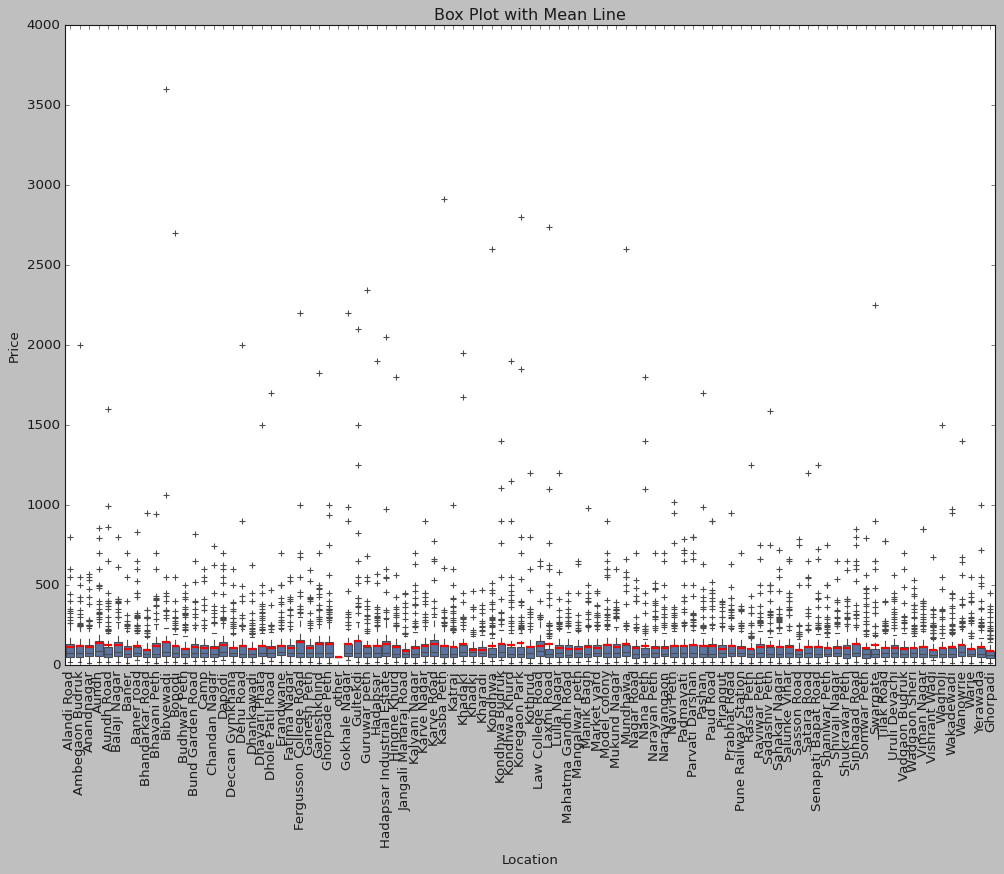

In [ ]:
# Box plot with a mean line
plt.figure(figsize=(15,10))
sns.boxplot(x='location', y='price', data=df, showmeans=True, meanline=True, meanprops={"color": "red", "linewidth": 2})
plt.title('Box Plot with Mean Line')
plt.xlabel('Location')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()


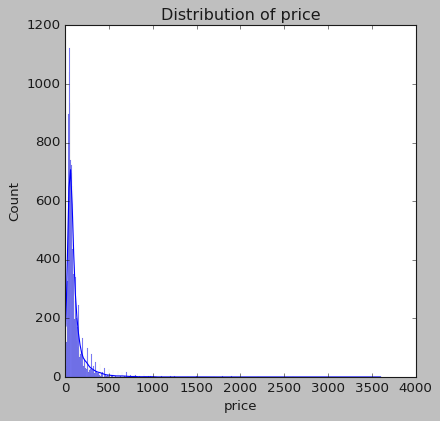

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = ['price']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True, color='blue', edgecolor='black')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


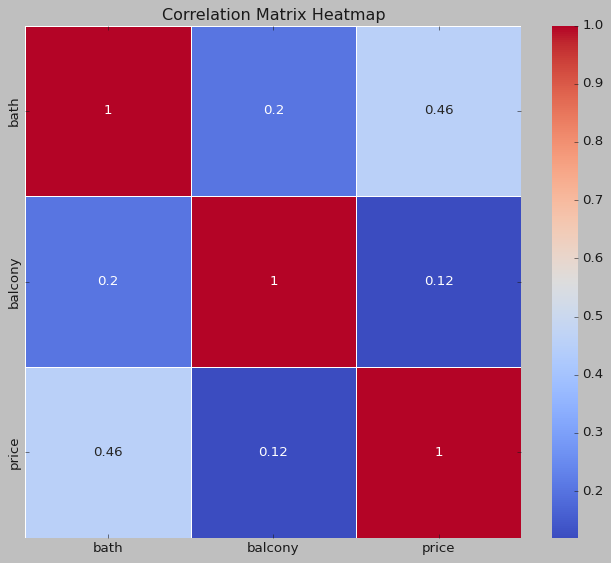

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns for the correlation matrix
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Generate correlation matrix for numerical features only
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with a color bar
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Add title and show plot
plt.title('Correlation Matrix Heatmap')
plt.show()



## data modeling'

In [ ]:
# Removing the unnecessary columns (columns that were added only for removing the outliers)
df6 = df5.copy()
df6 = df6.drop('price_per_sqft', axis='columns')

# Converting the categorical_value into numerical_values using get_dummies method
dummy_cols = pd.get_dummies(df6.location)
df6 = pd.concat([df6,dummy_cols], axis='columns')
df6.drop(['location'], axis='columns', inplace=True)

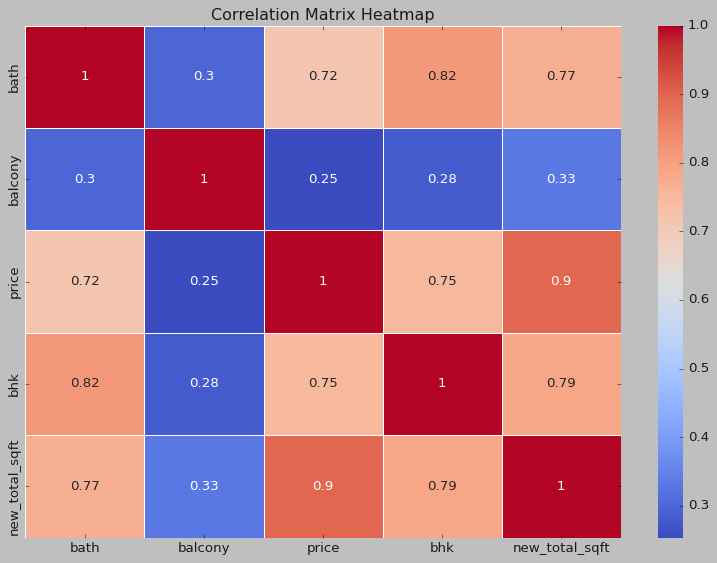

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix for numerical features
numeric_df = df6.select_dtypes(include=['float64', 'int64'])  # Selecting numerical columns
correlation_matrix = numeric_df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define features (X) and target (y)
X = df6.drop(columns=['price'])
y = df6['price']

# Train RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Display feature importances
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

print("Feature Importances:")
print(feature_importances)


Feature Importances:
                      importance
new_total_sqft          0.864638
balcony                 0.011820
bhk                     0.011038
bath                    0.002824
Mundhawa                0.002154
...                          ...
Dhankawadi              0.000683
Dhole Patil Road        0.000678
Pune Railway Station    0.000667
Khadaki                 0.000634
Law College Road        0.000597

[100 rows x 1 columns]


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% train, 20% test)
X = df6.drop('price', axis=1)
y = df6['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# importing nesessary libraries for modelling

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,confusion_matrix
import numpy as np
import pandas as pd

In [ ]:
# Define features and target variable

data=df6.copy()
X = data.drop('price',axis=1)
y = data['price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#model  LinearRegression

model= LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Linear Regression Results:\n")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))
print("\n")


Linear Regression Results:

MAE: 8.002071492457025
MSE: 92.86994186156909
RMSE: 9.63690520144144
R2 Score: 0.8215668286125672




In [ ]:
# Model DecisionTreeRegressor

model= DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"DecisionTreeRegressor Results:\n")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))
print("\n")


DecisionTreeRegressor Results:

MAE: 8.998929515418503
MSE: 138.61583099608418
RMSE: 11.773522454902109
R2 Score: 0.7336741917422169




In [ ]:
# Model RandomForestRegressor

model= RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"RandomForestRegressor Results:\n")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))
print("\n")


RandomForestRegressor Results:

MAE: 7.5444611634151455
MSE: 92.82022169953072
RMSE: 9.63432518132592
R2 Score: 0.8216623571120641




In [ ]:
# Model GradientBoostingRegressor

model= GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"GradientBoostingRegresso Results:\n")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))
print("\n")


GradientBoostingRegresso Results:

MAE: 7.6219185033932
MSE: 86.04362892961437
RMSE: 9.275970511467486
R2 Score: 0.8346823818358838




In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,confusion_matrix
import numpy as np
import pandas as pd

data=df6.copy()
# Define features and target variable
X = data.drop('price',axis=1)
y = data['price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{model_name} Results:")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R2 Score:", r2_score(y_test, y_pred))
    print("\n")

Linear Regression Results:
MAE: 8.002071492457025
MSE: 92.86994186156909
RMSE: 9.63690520144144
R2 Score: 0.8215668286125672


Decision Tree Results:
MAE: 9.071233480176211
MSE: 139.95846529123838
RMSE: 11.830404274209668
R2 Score: 0.7310945573578755


Random Forest Results:
MAE: 7.602130015838053
MSE: 93.75959607548161
RMSE: 9.68295389204563
R2 Score: 0.8198575153552894


Gradient Boosting Results:
MAE: 7.622264119621771
MSE: 86.048575083196
RMSE: 9.276237118745726
R2 Score: 0.8346728786763895




In [ ]:
# lets continue with linear regression model

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

data=df6.copy()
X = data.drop('price',axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
model=LinearRegression()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
r2=r2_score(y_test,y_pred)
print("r2 Score is =",r2)



r2 Score is = 0.83084567750188


In [ ]:

# Function to predict the price
def predict_price(location, bhk, bath, balcony, new_total_sqft):


    input_data = pd.DataFrame([[location, bhk, bath, balcony, new_total_sqft]],
                              columns=['location', 'bhk', 'bath', 'balcony', 'new_total_sqft'])

    # One-hot encode the location feature using the same categories as the training data
    dummy_cols = pd.get_dummies(input_data.location)
    input_data = pd.concat([input_data, dummy_cols], axis='columns')
    input_data.drop(['location'], axis='columns', inplace=True)

    # Align the input data columns with the training data columns
    missing_cols = set(X.columns) - set(input_data.columns)
    for col in missing_cols:
        input_data[col] = False  # Add missing columns with 0 values
    input_data = input_data[X.columns]  # Reorder columns to match X

    predicted_price = model.predict(input_data)[0]

    return round(predicted_price,2)


if __name__ == "__main__":
    bhk = int(input("Enter the number of BHK = "))
    balcony = int(input("Enter the number of balconies = "))
    bath = int(input("Enter the number of bathrooms = "))
    new_total_sqft = int(input("Enter the total sqft = "))
    location = input("Enter the location = ")

    price_prediction = predict_price(location, bhk, bath, balcony, new_total_sqft)
    print("The estimated price is:", price_prediction,"lakhs")


Enter the number of BHK = 1
Enter the number of balconies = 0
Enter the number of bathrooms = 1
Enter the total sqft = 450
Enter the location = Alandi Road
The estimated price is: 12.54 lakhs


In [ ]:

import tabulate as tb
print(tb.tabulate(df6.head(20),headers='keys',tablefmt='psql'))

+----+--------+-----------+---------+-------+------------------+---------------+-------------------+--------------+---------+--------------+----------------+---------+--------------+-------------------+----------------+-------------+----------+----------------+--------------------+--------+-----------------+----------+-------------------+-------------+--------------+-----------------+--------------------+-------------+----------------+--------------------------+---------------+---------------+-----------------+------------+-----------------+------------+----------------+------------+------------------------------+----------------+------------------------+-----------------+---------------+--------------+--------------+----------+-----------+----------+-----------+-----------+------------------+-----------------+-----------------+-----------+--------------------+--------------+---------------+-----------------------+------------------+--------------+---------------+----------------+-----